# MLP Lesson 2

## Google Cloud Storage Boilerplate

This first cell has some boilerplate to connect the Google Cloud Storage bucket containing the data used for this tutorial to the Google Colab environment. 

In order to access the data for this workshop you'll need to run this cell, follow the link when prompted and copy the Google SDK token into the prompt. If everything works correctly a new folder called `data` should appear in the file browser on the left.

In [1]:
%tensorflow_version 2.x
from google.colab import auth
auth.authenticate_user()

project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!gcloud config set project {project_id}

!mkdir data
!gcsfuse  --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_name} /content/data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  17184      0 --:--:-- --:--:-- --:--:-- 17184
OK
64 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 64 not upgraded.
Need to get 4,274 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.28.1_amd64.deb ...
Unpacking gcsfuse (0.28.1) ...
Setting up gcsfuse (0.28.1) ...
Updated property [core/project].
Using mount point: /content/data
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
from sklearn.utils import resample
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization

## Bigger data - deeper networks

The last exercise gave us an intro into how to build and tune some of the parameters of a neural network. Now we move to an example where we have more data. Generally as we increase the amount of training data we can make use of deeper networks, with more layers to give more accurate predictions.

This time around we load up the data from `ag-muon-data-tight.pkl`

You can load this up in the same way as in the previous notebook. We just take the first 50k examples to speed up training.

In [0]:
df = pd.read_pickle('/content/data/muon/ag-muon-data-tight.pkl').iloc[:90000]
X = np.array(df[3].to_list())
y = np.array(df[1].to_list())

## Class imbalance 
Don't forget to take care of class balance in your dataset. Do the same checks and use the `resample` function as you did in the previous notebook. Plot a historgram of the class balance.

(array([32196.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 32196.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

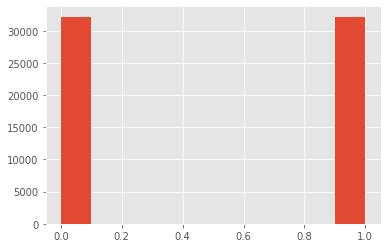

In [4]:
num_ag = np.count_nonzero(y==0)
num_no_ag = np.count_nonzero(y==1)

df_majority = df[df[1]==0]
df_minority = df[df[1]==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_no_ag,     # to match minority class
                                 random_state=123) # reproducible results

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_new = df_downsampled.sample(frac=1)

X = np.array(df_new[3].to_list())
y = np.array(df_new[1].to_list())
plt.hist(y)

### Initial network

We now have more data, so we could think about making a deeper network. Try out the architecture below. **Note** this needs to run for more epochs as the network takes some time to equilibrate, so a little bit of patience is needed. If you like you can try stopping it earlier (running fewer epochs), then plot the training and validation loss to see how it is doing.

In [5]:
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
history_bn = model.fit(X, y, epochs=200, batch_size=64, validation_split=0.2)

Epoch 1/200
805/805 [==============================] - 5s 6ms/step - loss: 0.6985 - accuracy: 0.5168 - val_loss: 0.6887 - val_accuracy: 0.5376
Epoch 2/200
805/805 [==============================] - 5s 6ms/step - loss: 0.6717 - accuracy: 0.5844 - val_loss: 0.7332 - val_accuracy: 0.5073
Epoch 3/200
805/805 [==============================] - 5s 6ms/step - loss: 0.5395 - accuracy: 0.7427 - val_loss: 0.4361 - val_accuracy: 0.8064
Epoch 4/200
805/805 [==============================] - 5s 6ms/step - loss: 0.2931 - accuracy: 0.8934 - val_loss: 0.4095 - val_accuracy: 0.7932
Epoch 5/200
805/805 [==============================] - 5s 6ms/step - loss: 0.1320 - accuracy: 0.9589 - val_loss: 0.6255 - val_accuracy: 0.7017
Epoch 6/200
805/805 [==============================] - 4s 6ms/step - loss: 0.0960 - accuracy: 0.9679 - val_loss: 0.2157 - val_accuracy: 0.9129
Epoch 7/200
805/805 [==============================] - 4s 6ms/step - loss: 0.0820 - accuracy: 0.9705 - val_loss: 0.2091 - val_accuracy: 0.9097

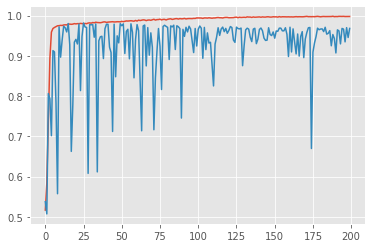

In [6]:
plt.plot(history_bn.history['accuracy'])
plt.plot(history_bn.history['val_accuracy'])